In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchtsmixer import TSMixer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from src.training import train_tsmixer,train_latent_tsmixer

#add a path to the system path
import sys
sys.path.append('../')
from experiments.datasets import *

seed=42
torch.manual_seed(seed)

In [3]:
sequence_length = 40
prediction_length = 20
input_channels = 1
n_samples=100
n_timesteps=sequence_length+prediction_length

#generate a Sine dataset
Dataset_generator=SineDataset_AR(n_samples=n_samples, n_timesteps=n_timesteps)
X,ts,ys=Dataset_generator.get_X_ts_ys()

Ys=np.array(ys)
X_torch=torch.tensor(Ys[:,:sequence_length]).float().reshape(n_samples,sequence_length,1)
Y_torch=torch.tensor(Ys[:,sequence_length:]).float().reshape(n_samples,prediction_length,1)
print(X_torch.shape,Y_torch.shape)

torch.Size([100, 40, 1]) torch.Size([100, 20, 1])


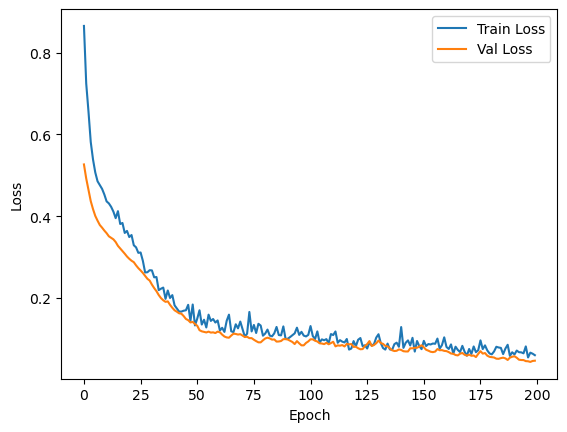

In [4]:
model= TSMixer(
    sequence_length=sequence_length,
    prediction_length=prediction_length,
    input_channels=input_channels,
)

best_model, curves, test_loss,test_dataset  = train_tsmixer(
    model,
    X_torch,
    Y_torch,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    epochs=200,
    batch_size=32,
    lr=1e-3,
    device="cpu"  # or "cpu"
)

plt.plot(curves[0], label='Train Loss')
plt.plot(curves[1], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

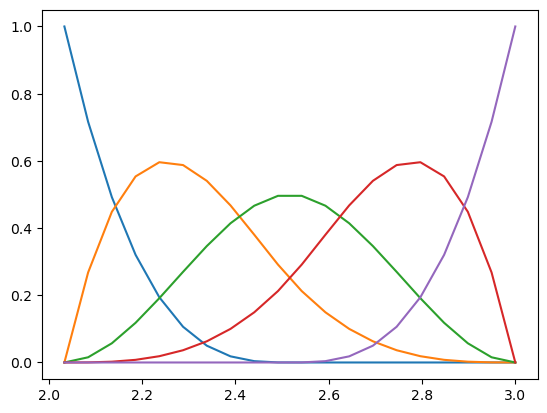

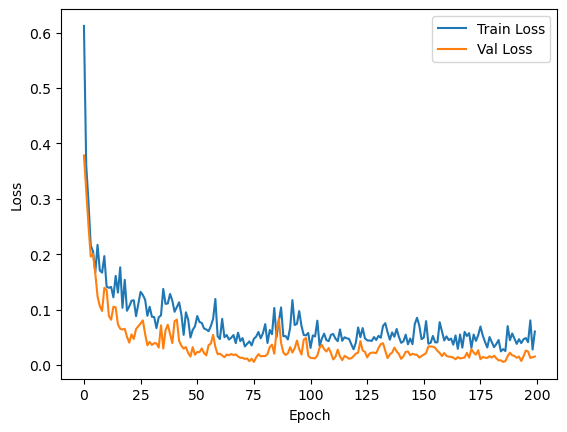

In [5]:
from timeview.basis import BSplineBasis
B=5
t=ts[0][sequence_length:]
# Flatten all time arrays together

bspline=BSplineBasis(n_basis=B,t_range=(t[0],t[-1]))
Phis = list(bspline.get_all_matrices(np.array(ts)[:,sequence_length:])) # (D, sequence_length, B)

for i in range(B):
    plt.plot(t,Phis[0][:,i])
plt.show()

latent_model = TSMixer(
    sequence_length=sequence_length,   # same as time steps in X
    prediction_length=B, # number of spline coefficients to predict
    input_channels=1,
)

best_latent_model, curves, test_loss,test_dataset = train_latent_tsmixer(
    latent_model,
    X_torch,
    Y_torch,
    Phis,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    epochs=200,
    batch_size=32,
    lr=0.01,
    device="cpu"  # or "cuda"
)

plt.plot(curves[0], label='Train Loss')
plt.plot(curves[1], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

C:\Users\nicolas.i.fierro\AppData\Local\Temp\ipykernel_8368\2414320877.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  y_pred=torch.matmul(torch.Tensor(Phis)[0],h_pred).flatten().detach().numpy()


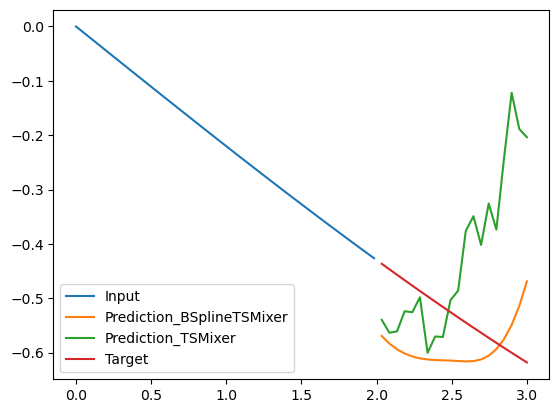

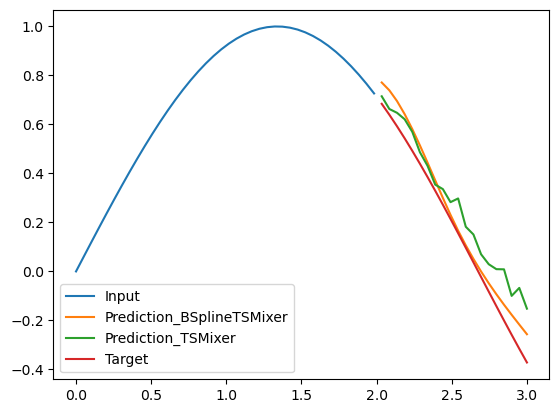

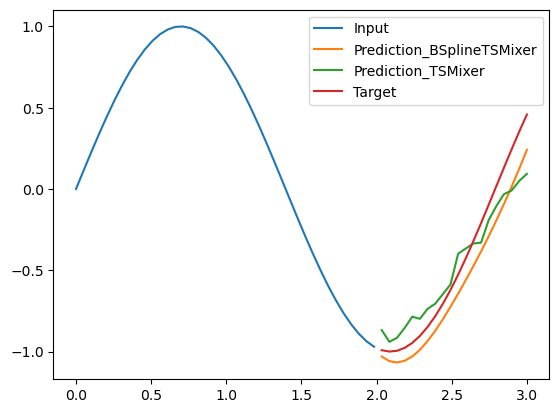

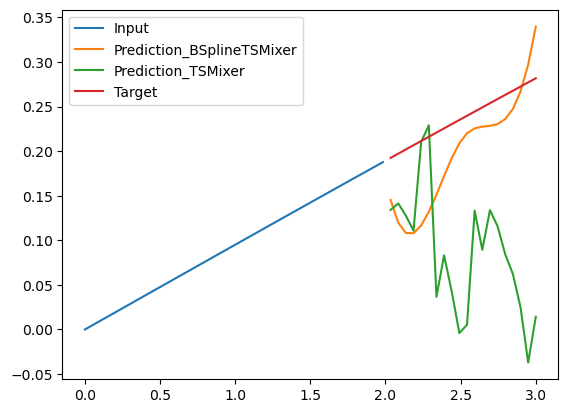

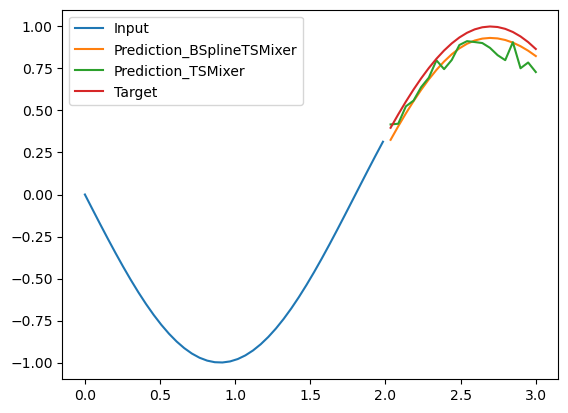

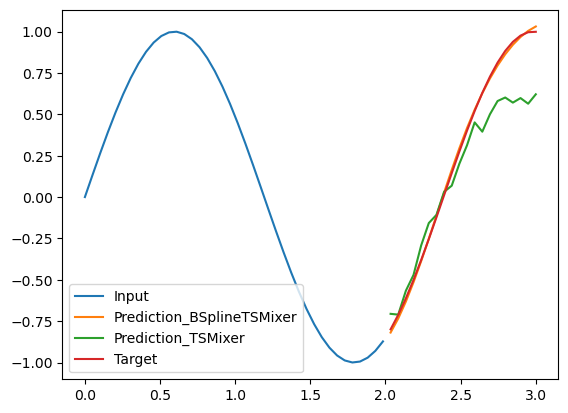

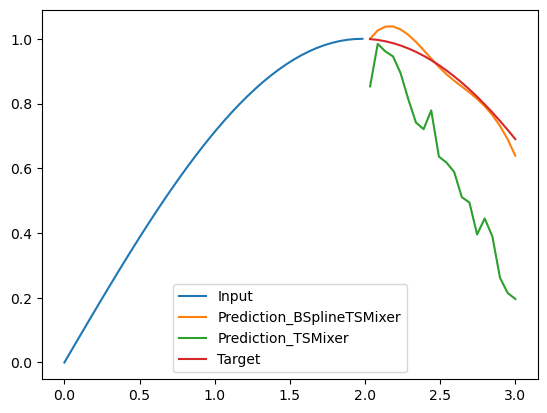

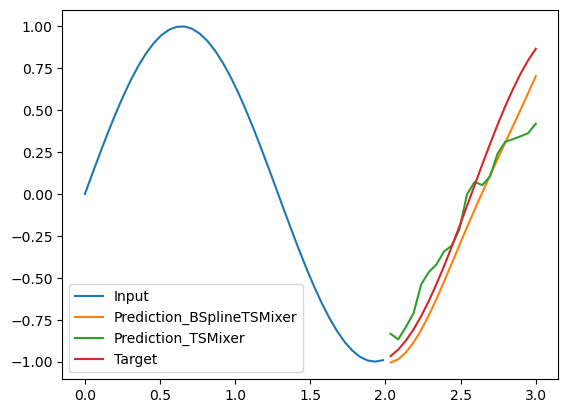

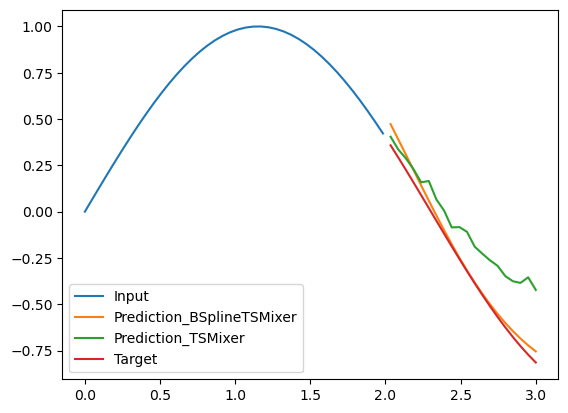

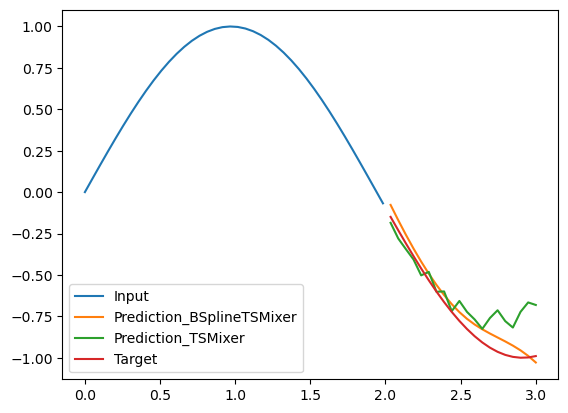

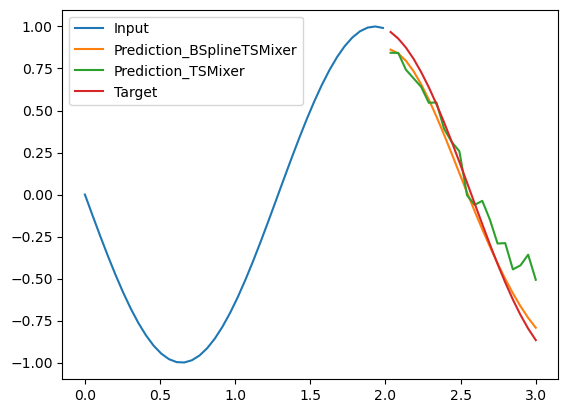

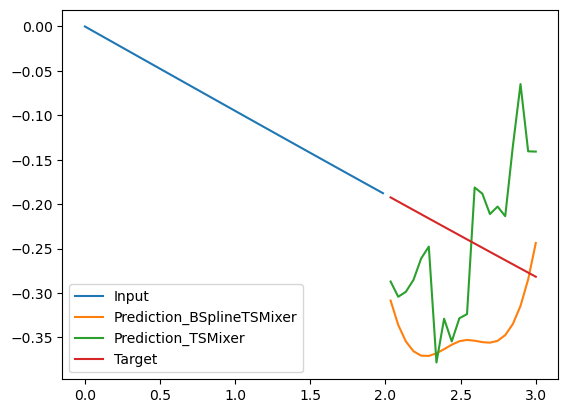

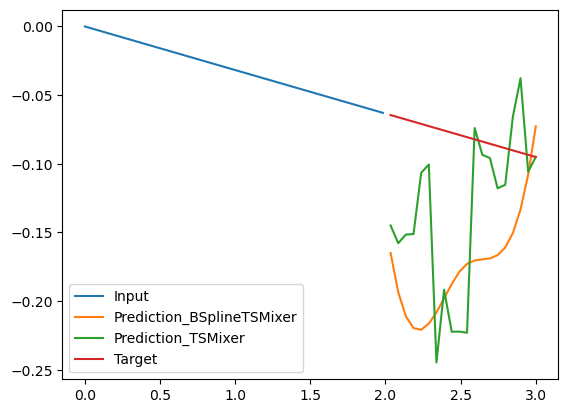

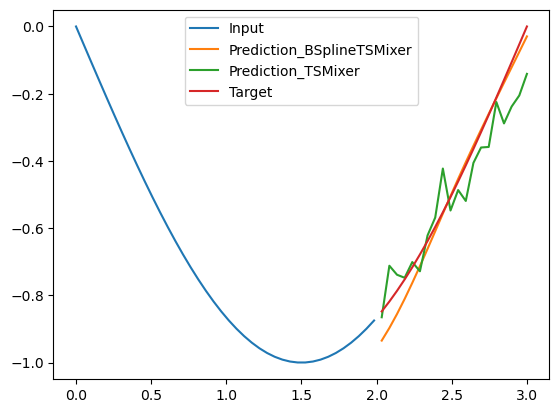

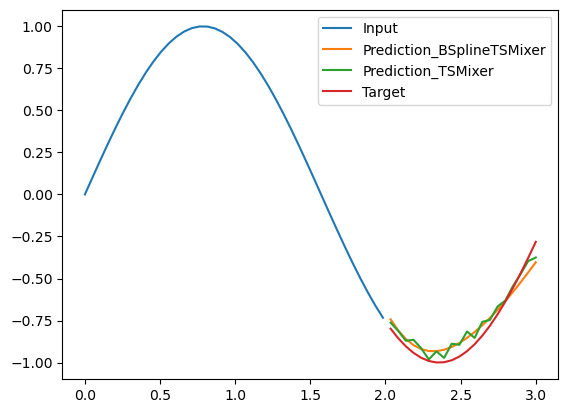

In [7]:
for idx in range(15):
    x_example=test_dataset.__getitem__(idx)[0]
    y_example=test_dataset.__getitem__(idx)[1]

    best_latent_model.eval()
    with torch.no_grad():
        h_pred = latent_model(x_example.unsqueeze(0))
    y_pred=torch.matmul(torch.Tensor(Phis)[0],h_pred).flatten().detach().numpy()

    best_model.eval()
    with torch.no_grad():
        pred = best_model(x_example.unsqueeze(0))

    plt.plot(ts[0][:sequence_length],x_example.squeeze().numpy(), label='Input')
    plt.plot(ts[0][sequence_length:],y_pred,label='Prediction_BSplineTSMixer')
    plt.plot(ts[0][sequence_length:], pred.squeeze().numpy(), label='Prediction_TSMixer')
    plt.plot(ts[0][sequence_length:], y_example.squeeze().numpy(), label='Target')
    plt.legend()
    plt.show()